In this demonstration, we 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerPerceptron
from models import KerasSimpleRNN, KerasGRU
from sklearn import metrics

Using TensorFlow backend.


### Data
Here, we generate a toy data set alternating between two points in 2-D space, plus a small amount of noise. Instead of refering to locations in space, the two "events" in the toy system refer to periods of either (1) oscilating between the two locations or (2) remaining at the same location.

In [2]:
def t_a(x):
    return [(x[0] + 1) % 2, (x[0] + 1) % 2]

def t_b(x):
    return x

In [3]:
def gen_data(N=40, beta=0.1, h_a=0.20, h_b=0.20):
    """
    Parameters
    ----------
    N: int
        sample size
    beta: float
        gaussian noise for scene vectors
    h_a: float [0, 1]
        hazard rate
    h_b: float [0, 1]
        hazard rate
        
    Returns
    -------
        x: Nx2 np.array
            scene vectors
        y: N np.array
            event type labels
    """
    
    # initialize
    x = [np.random.rand(2) < 0]
    y = [0]
    y0 = y[-1]

    use_a = True
    f = t_a
    h = h_a

    for _ in range(N):

        x.append(f(x[-1]))
        y.append(y0)

        if np.random.rand() < h:
            use_a = not use_a
            y0 = (y[-1] + 1) % 2

            if use_a:
                f = t_a
                h = h_a
            else:
                f = t_b
                h = h_b


    # noise
    beta = 0.01

    x = np.array(x) + np.random.randn(np.shape(x)[0], np.shape(x)[1]) * beta
    return x, np.array(y)


def correlation_boundary_feature_true(x, y):
    """ get the correlation between the feature changes and the
    inferred segmentation boundaries """
    
    # correlate feature changes with boundaries
    x_change = np.abs(np.round(x[1:, 1] - x[:-1, 0]))
    y_change = np.abs(np.round(y[1:] - y[:-1]))

    return np.corrcoef(x_change, y_change)[0][1]



# !

Correlation between feature changes and boundaries 0.0289036656508


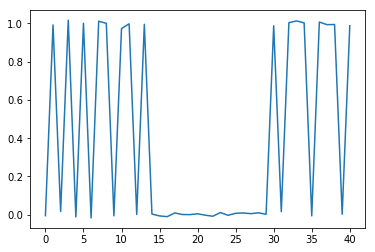

In [4]:
x, y = gen_data()
print "Correlation between feature changes and boundaries", correlation_boundary_feature_true(x, y)
plt.plot(x[:, 0])

In [5]:
D = 1
x_train = x[:-1]; y_train = x[1:]
y = y[:-1]

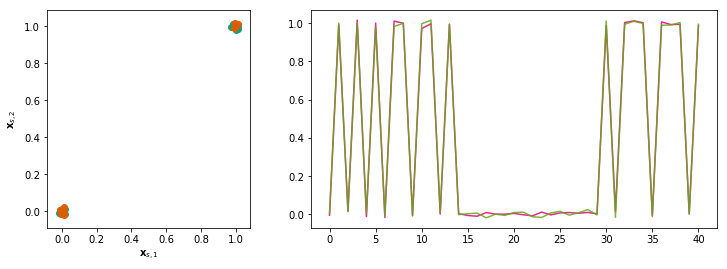

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
cc = sns.color_palette('Dark2')
for clt in set(y):
    idx = np.nonzero(y == clt)[0]
    axes[0].scatter(x[idx, 0], x[idx, 1], color=cc[clt], alpha=1.0)
axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


axes[1].plot(x[:, 0], color=cc[3])
axes[1].plot(x[:, 1], color=cc[4], alpha=0.85)
# axes[1].plot(y, color='k')
# axes[1].set_x

Now, we define some toy problem

In [7]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 10.0  # stickyness parameter
alfa = 0.5  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def correlation_boundary_feature(x, p):
    """ get the correlation between the feature changes and the
    inferred segmentation boundaries """
    
    # correlate feature changes with boundaries
    x_change = np.abs(np.round(x[1:, 1] - x[:-1, 0]))
    y_hat = np.argmax(p, axis=1)
    y_hat_change = np.abs(np.round(y_hat[1:] - y_hat[:-1]))

    return np.corrcoef(x_change, y_hat_change)[0][1]

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print "Correlation between feature change and boundaries:", correlation_boundary_feature(x_train, post)
    print 
    print np.argmax(post, axis=1)
    

## Naive model
Here, we train segment the data with no pre-training 


Adjusted Mutual Information: 0.101007533281
Adjusted Rand Score: 0.138002486531
Correlation between feature change and boundaries: 0.677003200386

[0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0
 0 0 1]


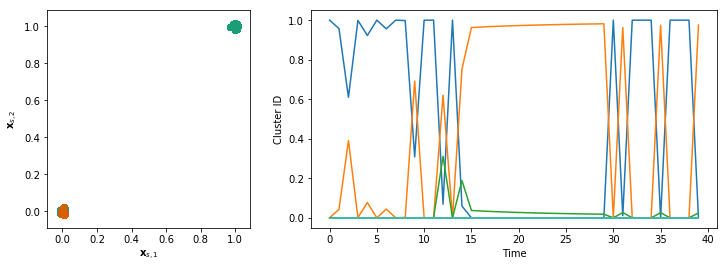

In [8]:
# Initialize keras model
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSimpleRNN, f_opts=dict(t=2))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

## Same as above, but with pretraining

In [ ]:
x_pretrain, y_pretrain = gen_data(500)

In [ ]:
sem = SEM(**sem_kwargs)
sem.pretrain(x_pretrain, y_pretrain)
post = sem.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

In [ ]:
plt.plot(y)

In [ ]:
plt.plot(x_train[:, 0])